In [2]:
import sys
sys.path.append('..')
import numpy as np
from torch.utils.data import DataLoader
from config import config
from loader import LSPMPIILIP
from transforms import *
from utils import display_one_img
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
trainloader = DataLoader(
    LSPMPIILIP(os.path.join('..', config.train_json_file), 
        os.path.join('..', config.train_img_dir), 
        config.size, 
        config.num_kpt,
        config.s,
        trans = Compose([
            RandomAddColorNoise(config.num_kpt, config.min_gauss, config.max_gauss, config.percentage),
            RandomBrightnessContrast(config.num_kpt, config.min_alpha, config.max_alpha),
            RandomCrop(config.num_kpt, config.ratio_max_x, config.ratio_max_y, config.center_perturb_max),
            RandomRotate(config.num_kpt, config.max_degree),
            RandomHorizontalFlip(config.num_kpt, config.prob),
            Resized(config.num_kpt, config.size),
        ])), batch_size=config.batch_size, shuffle=True, 
    num_workers=config.num_workers, pin_memory=True)

NameError: name 'cfg' is not defined

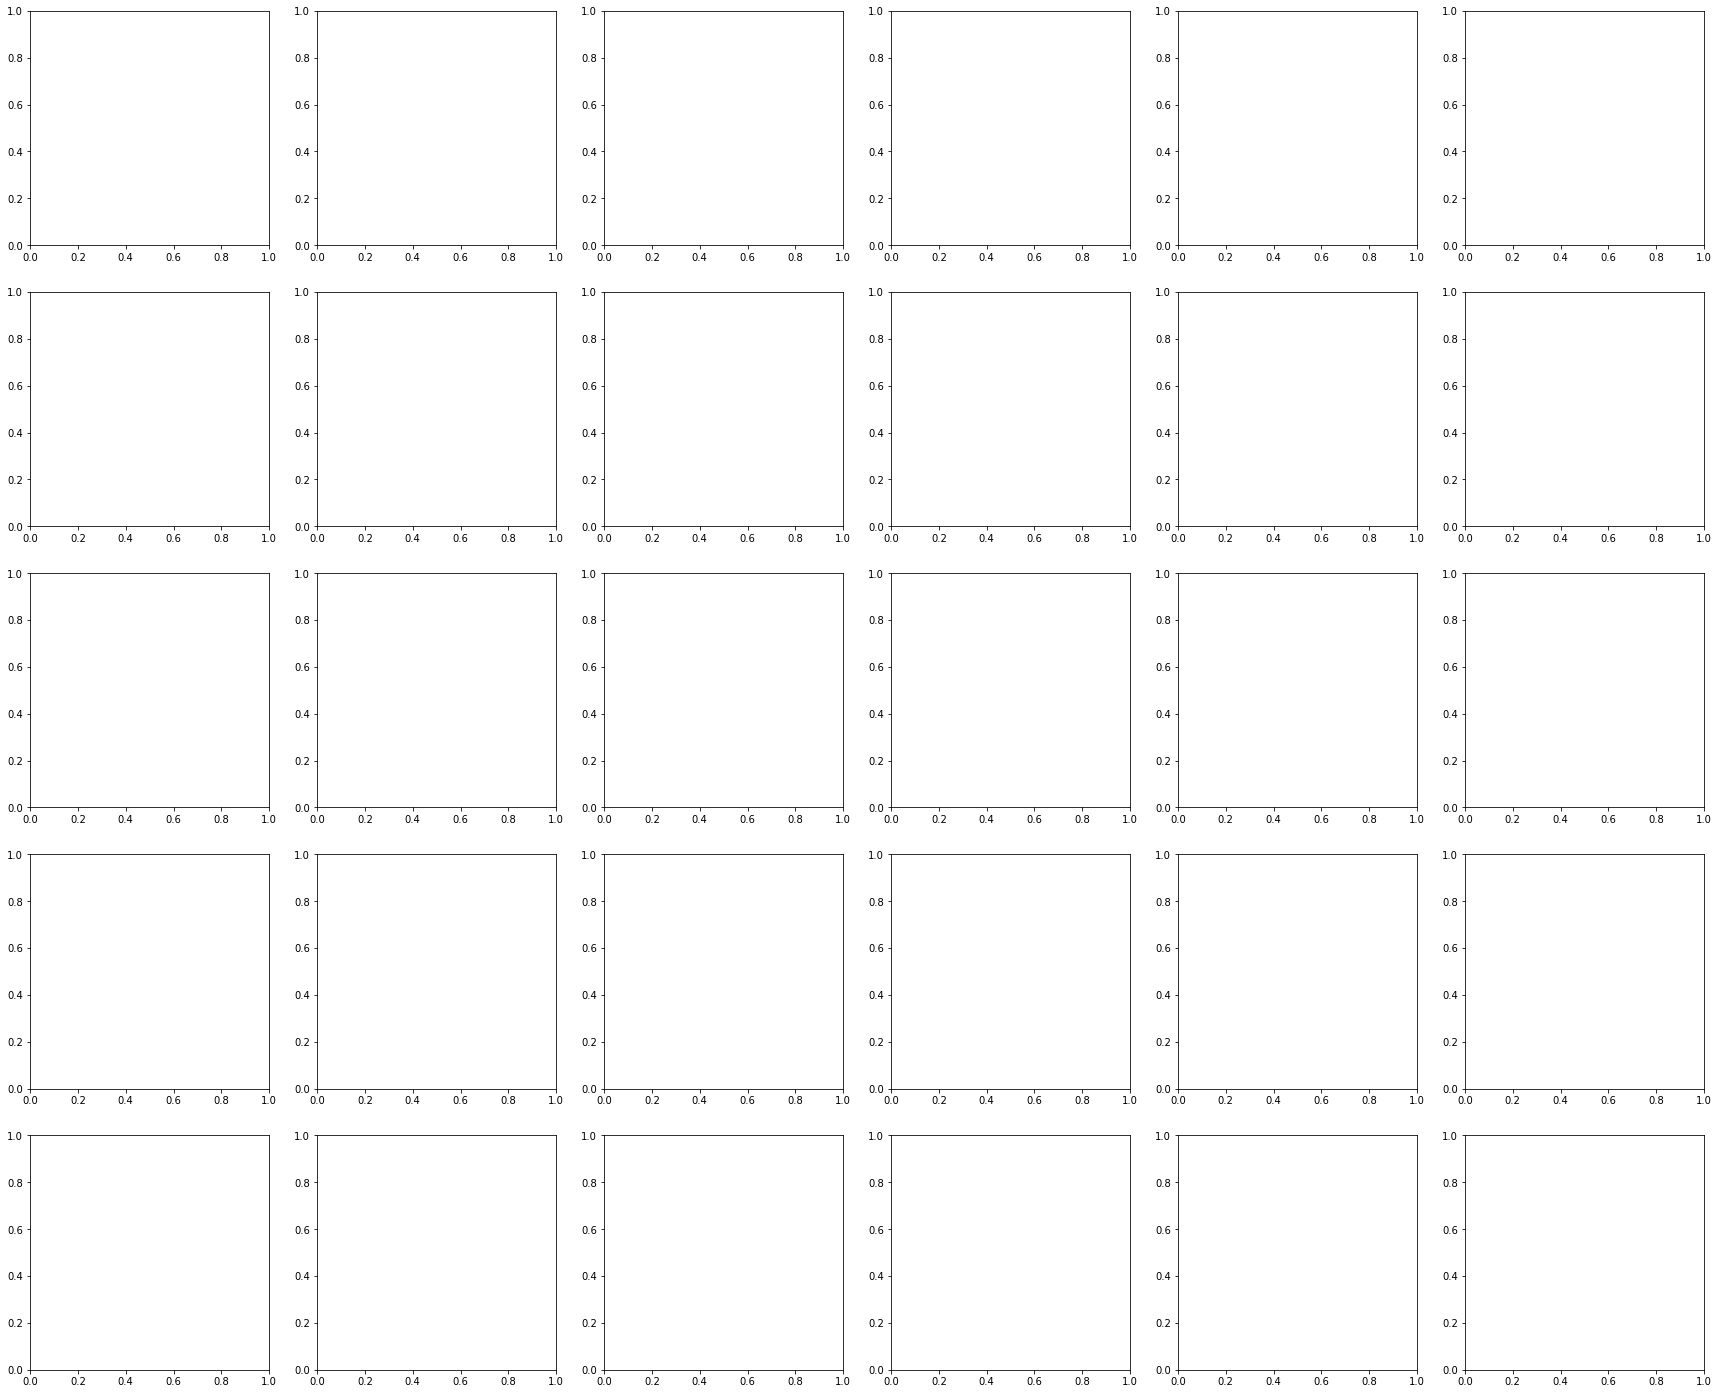

In [7]:
f, axarr = plt.subplots(5, 6, figsize=(30, 25))
x_ticks = np.arange(0, config.size, config.size / config.s)
y_ticks = np.arange(0, config.size, config.size / config.s))
for (img, target_heat, target_off) in trainloader:
    print(img.shape, target_heat.shape, target_off.shape)
    img = np.transpose(img[0].numpy(), [1, 2, 0]) + 0.5
    target_heat = target_heat[0].numpy()
    target_off = target_off[0].numpy()
    keypoints = [0] * (config.num_kpt * 3)
    for idy in range(5):
        for idx in range(6):
            px = ((idy * 6 + idx) - 2) // 2
            if px >= 0:
                axarr[idy][idx].imshow(img, alpha=0.5)
                axarr[idy][idx].grid(c='r')
                axarr[idy][idx].set_xticks(x_ticks)
                axarr[idy][idx].set_yticks(y_ticks)
                locs = np.argwhere(target_heat[px])
                grid_y, grid_x = None, None
                if len(locs) > 0:
                    grid_y, grid_x = locs[0]
                if idx % 2 == 0 and grid_x is not None and grid_y is not None: # heat
                    rect = plt.Rectangle((grid_x * 32, grid_y * cfg.grid_size[0]), 
                        config.grid_size[1], cfg.grid_size[0], edgecolor='r',facecolor='r')
                    axarr[idy][idx].add_patch(rect)
                elif idx % 2 == 1 and grid_x is not None and grid_y is not None: # off
                    off_x = target_off[px, grid_y, grid_x]
                    off_y = target_off[cfg.num_kpt+px, grid_y, grid_x]
                    kpt_x = (grid_x + off_x) * cfg.grid_size[1]
                    kpt_y = (grid_y + off_y) * cfg.grid_size[0]
                    keypoints[px * 3 + 0] = kpt_x
                    keypoints[px * 3 + 1] = kpt_y
                    keypoints[px * 3 + 2] = 1
                    axarr[idy][idx].plot([kpt_x, grid_x * cfg.grid_size[1]], [kpt_y, kpt_y], color='r', linewidth=2, linestyle=':') # x line
                    axarr[idy][idx].plot([kpt_x, kpt_x], [kpt_y, grid_y * cfg.grid_size[0]], color='r', linewidth=2, linestyle=':') # y line
            else:
                axarr[idy][idx].imshow(img)
    display_one_img(axarr[0][1], keypoints, cfg.limbSeq, cfg.colors)
    break